## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file
file_name = '/content/sample_data/complaints-2021-05-14_08_16.json'
f = open(file_name)

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
df.size

1722886

In [6]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [7]:
#Assign new column names
df.rename(columns={
    '_index': 'index',
    '_type': 'type',
    '_id': 'id',
    '_score': 'score',
    '_source.tags': 'tags',
    '_source.zip_code': 'zip_code',
    '_source.complaint_id': 'complaint_id',
    '_source.issue': 'complaint_title',
    '_source.date_received': 'date_received',
    '_source.state': 'state',
    '_source.consumer_disputed': 'consumer_disputed',
    '_source.product': 'product',
    '_source.company_response': 'company_response',
    '_source.company': 'company',
    '_source.submitted_via': 'submitted_via',
    '_source.date_sent_to_company': 'date_sent_to_company',
    '_source.company_public_response':'company_public_response',
    '_source.sub_product': 'sub_product',
    '_source.timely': 'timely',
    '_source.complaint_what_happened':'complaint_what_happened',
    '_source.sub_issue':'complaint_desc',
    '_source.consumer_consent_provided':'consumer_consent_provided'
}, inplace=True)

In [8]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,complaint_title,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,complaint_desc,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [9]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'] = df['complaint_what_happened'].replace(r'^\s*$', np.nan, regex=True)

In [10]:
# Count the number of rows where 'complaint_what_happened' is NaN
nan_complaint_count = df['complaint_what_happened'].isna().sum()

print(f"Number of rows with NaN complaint_what_happened: {nan_complaint_count}")

Number of rows with NaN complaint_what_happened: 57241


In [11]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)

In [12]:
df.size

463584

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [13]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(df, col_name):
    # Make a copy to avoid modifying the original DataFrame
    df_cleaned = df.copy()

    # Convert text to lowercase
    df_cleaned[col_name] = df_cleaned[col_name].str.lower()

    # Remove square brackets and their contents
    df_cleaned[col_name] = df_cleaned[col_name].apply(lambda x: re.sub(r'\[.*?\]', '', str(x)))

    # Remove punctuation
    df_cleaned[col_name] = df_cleaned[col_name].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))

    # Remove words containing numbers
    df_cleaned[col_name] = df_cleaned[col_name].apply(lambda x: re.sub(r'\b\w*\d\w*\b', '', str(x)))

    return df_cleaned

#call the new clean text function
df = clean_text(df, 'complaint_what_happened')

In [15]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,complaint_title,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,complaint_desc,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in and was told ...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on however fraudulent...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on while trying to book a xxxx xxxx ticket ...,Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for i deposit it i...,Funds not handled or disbursed as instructed,Consent provided


In [16]:
#Write your function to Lemmatize the texts
def lemmatize_text(df, column_name):
    # Create a new column for lemmatized text
    df['lemmatized_text'] = ''

    # Iterate through each row of the DataFrame
    for index, row in df.iterrows():
        text = row[column_name]
        doc = nlp(text)
        lemmas = [token.lemma_ for token in doc]
        df.loc[index, 'lemmatized_text'] = " ".join(lemmas)  # Join lemmas back into a string

    return df

df = lemmatize_text(df, 'complaint_what_happened')

In [17]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,complaint_title,date_received,state,...,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,complaint_desc,consumer_consent_provided,lemmatized_text
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name be xxxx xxxx and I apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in and was told ...,Problem with rewards from credit card,Consent provided,I upgrade my xxxx xxxx card in and be tell b...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on however fraudulent...,Information belongs to someone else,Consent provided,chase card be report on however fraudulent a...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on while trying to book a xxxx xxxx ticket ...,Information belongs to someone else,Consent provided,on while try to book a xxxx xxxx ticket ...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for i deposit it i...,Funds not handled or disbursed as instructed,Consent provided,my grand son give I check for I deposit it i...


In [39]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = df[['complaint_what_happened', 'lemmatized_text']].copy()

In [40]:
#Write your function to extract the POS tags
def cleanse_pos_tag(text, pos_tag_type, retain_flag):
    doc = nlp(text)
    pos_tags = [token.pos_ for token in doc]
    filtered_text = []
    for word, tag in zip(text.split(), pos_tags):
      if retain_flag:
        if tag == pos_tag_type:
          filtered_text.append(word)
      else:
        if tag != pos_tag_type:
          filtered_text.append(word)

    return " ".join(filtered_text)

#gernerate the column that should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean['complaint_POS_removed'] = df.apply(lambda x: cleanse_pos_tag(x['lemmatized_text'], 'NOUN', True), axis=1)

In [41]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,lemmatized_text,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service debt and what b...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card who date would be in to xxxx change ...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report have without to do without of
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx I across be for in my and than the could ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son account after clear bank close never they ...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




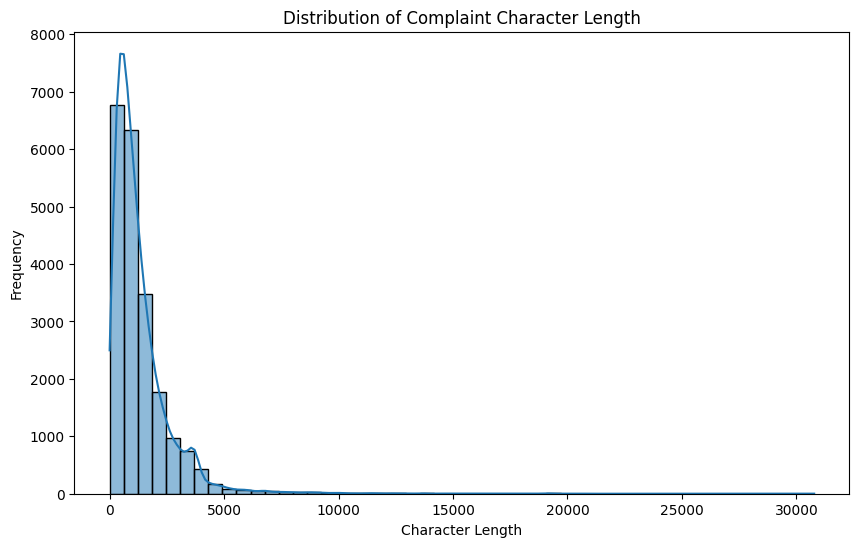

In [42]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_length'] = df_clean['complaint_what_happened'].str.len()

# Create the visualization
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['complaint_length'], bins=50, kde=True)
plt.title('Distribution of Complaint Character Length')
plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

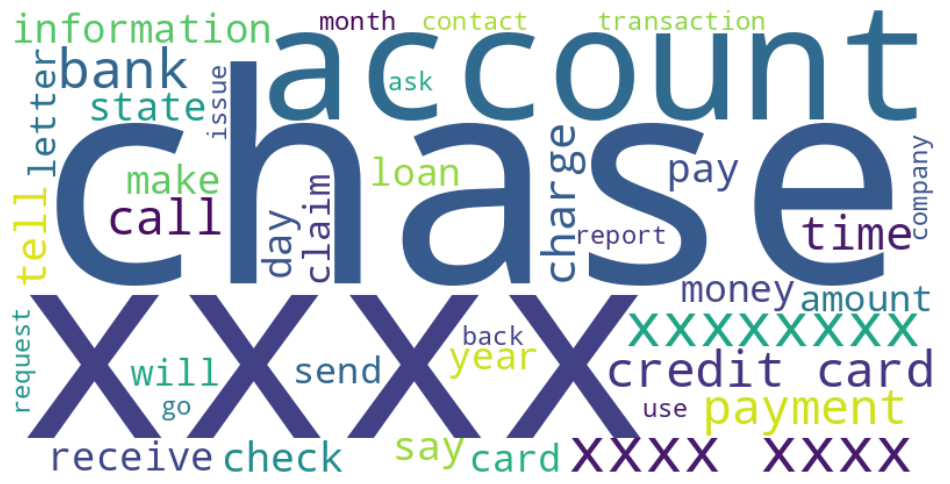

In [43]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud, STOPWORDS

# Combine all processed complaints into a single string
text = " ".join(df_clean['complaint_POS_removed'].astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, max_words=40, background_color='white').generate(text)

# Display the generated image:
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [46]:
#Removing -PRON- from the text corpus
df_clean['clean_complaint'] = df_clean.apply(lambda x: cleanse_pos_tag(x['complaint_POS_removed'], 'PRON', False), axis=1)

In [47]:
#complaint_POS_removed column is now have all PRON removed.
df_clean.head()

,complaint_what_happened,lemmatized_text,complaint_POS_removed,complaint_length,clean_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service debt and what b...,475,morning name stop bank service debt and be val...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card who date would be in to xxxx change ...,337,xxxx card date would be in to xxxx change from...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report have without to do without of,210,chase card report have without to do without of
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx I across be for in my and than the could ...,1433,xxxx across be for in and than could make to c...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son account after clear bank close never they ...,456,son account after clear bank close never check...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

be 43744
xxxx 41766
the 38136
to 36148
and 33131
chase 22715
of 18662
account 17048
have 16608
card 13740
in 13244
on 13202
credit 12840
not 12318
for 11887
that 9333
with 9148
bank 7921
xxxxxxxx 7800
do 7423
from 6979
payment 6770
as 5913
call 5635
charge 5136
time 4715
check 4627
report 4560
at 4382
by 4209


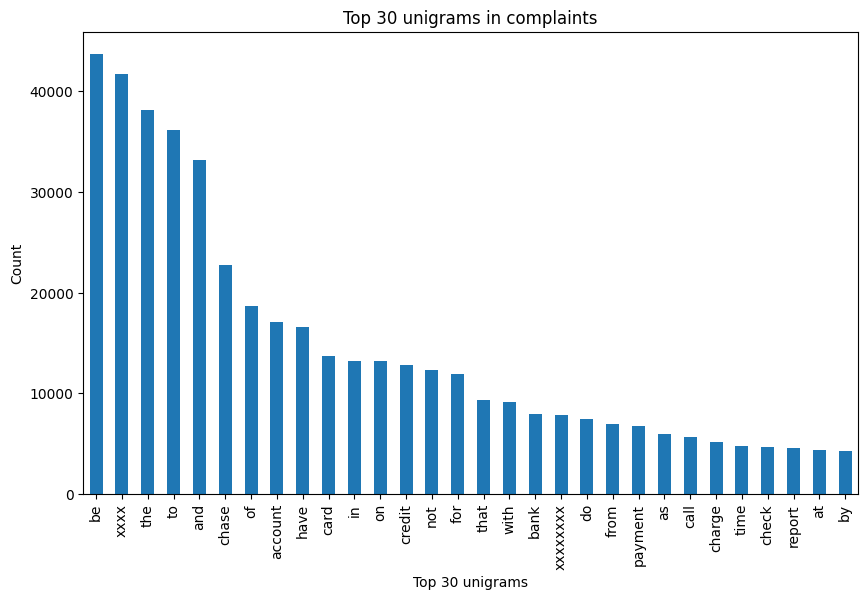

In [48]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
from collections import Counter

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df_clean['clean_complaint'], 30)

for word, freq in common_words:
    print(word, freq)

df2 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    xlabel="Top 30 unigrams",
    ylabel="Count",
    title="Top 30 unigrams in complaints"
)
plt.show()

In [49]:
#Print the top 10 words in the unigram frequency
print(common_words[:10])

[('be', 43744), ('xxxx', 41766), ('the', 38136), ('to', 36148), ('and', 33131), ('chase', 22715), ('of', 18662), ('account', 17048), ('have', 16608), ('card', 13740)]


xxxx xxxx 7226
credit card 4585
the be 2459
be to 2097
and be 2050
be be 1895
be the 1854
to the 1820
be and 1780
the the 1716
to be 1642
xxxx be 1638
and to 1544
to and 1488
the xxxx 1479
xxxx and 1386
be xxxx 1271
and the 1269
to xxxx 1267
credit report 1261
to to 1243
xxxx the 1163
xxxx to 1153
of the 1098
and and 1025
be not 1023
have be 996
chase credit 969
and xxxx 917
of and 908


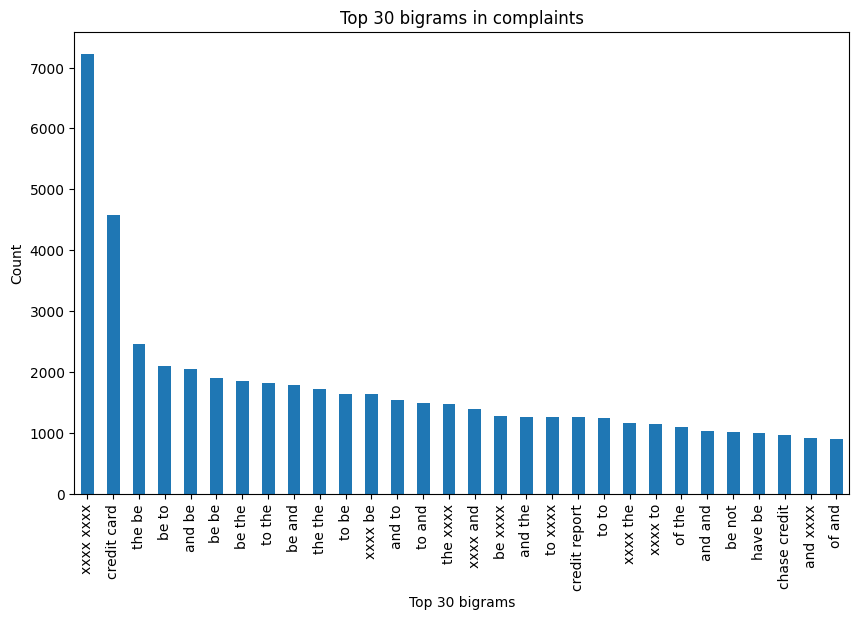

In [50]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df_clean['clean_complaint'], 30)

for word, freq in common_words:
    print(word, freq)

df3 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

df3.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    xlabel="Top 30 bigrams",
    ylabel="Count",
    title="Top 30 bigrams in complaints"
)
plt.show()

In [51]:
#Print the top 10 words in the bigram frequency
print(common_words[:10])

[('xxxx xxxx', 7226), ('credit card', 4585), ('the be', 2459), ('be to', 2097), ('and be', 2050), ('be be', 1895), ('be the', 1854), ('to the', 1820), ('be and', 1780), ('the the', 1716)]


xxxx xxxx xxxx 1800
chase credit card 697
credit card account 384
xxxx credit card 295
xxxx xxxx be 255
credit card chase 252
credit card company 215
the xxxx xxxx 212
be xxxx xxxx 198
to xxxx xxxx 193
xxxx xxxx to 176
xxxx xxxx and 176
inquiry credit report 161
xxxx xxxx the 160
be the be 140
be and be 135
freedom credit card 134
victim identity theft 132
and xxxx xxxx 132
credit card credit 131
credit card xxxx 129
the the be 127
xxxx and xxxx 125
on xxxx xxxx 125
the be to 120
the be be 119
be to be 115
of xxxx xxxx 115
chase xxxx xxxx 115
be the the 111


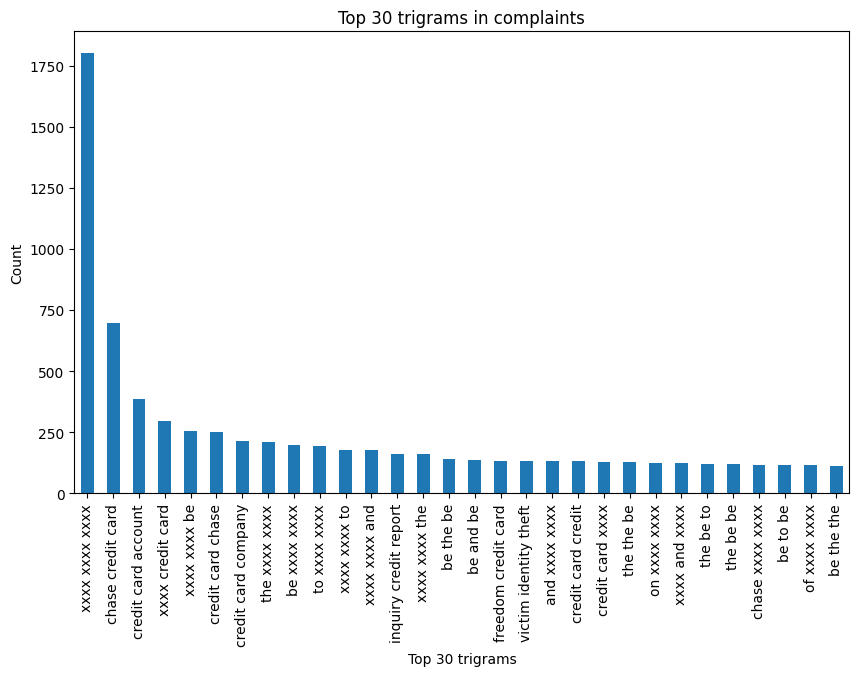

In [52]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(df_clean['clean_complaint'], 30)

for word, freq in common_words:
    print(word, freq)

df4 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

df4.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    xlabel="Top 30 trigrams",
    ylabel="Count",
    title="Top 30 trigrams in complaints"
)
plt.show()


In [53]:
#Print the top 10 words in the trigram frequency
print(common_words[:10])

[('xxxx xxxx xxxx', 1800), ('chase credit card', 697), ('credit card account', 384), ('xxxx credit card', 295), ('xxxx xxxx be', 255), ('credit card chase', 252), ('credit card company', 215), ('the xxxx xxxx', 212), ('be xxxx xxxx', 198), ('to xxxx xxxx', 193)]


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [54]:
df_clean['clean_complaint'] = df_clean['clean_complaint'].str.replace('xxxx','')

In [55]:
#All masked texts has been removed
df_clean.head()

,complaint_what_happened,lemmatized_text,complaint_POS_removed,complaint_length,clean_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service debt and what b...,475,morning name stop bank service debt and be val...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card who date would be in to xxxx change ...,337,card date would be in to change from have t...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report have without to do without of,210,chase card report have without to do without of
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx I across be for in my and than the could ...,1433,across be for in and than could make to conta...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son account after clear bank close never they ...,456,son account after clear bank close never check...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [56]:
#Write your code here to initialise the TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.95, min_df=2)
tfidf

TfidfVectorizer(max_df=0.95, min_df=2)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [57]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['clean_complaint'])
dtm

<21072x6811 sparse matrix of type '<class 'numpy.float64'>'
	with 652153 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [58]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [59]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [61]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

6811

In [62]:
#Print the Top15 words for each of the topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 15
display_topics(nmf_model, tfidf.get_feature_names_out(), no_top_words)

Topic 0:
be the to and of have on in not for that with do from chase
Topic 1:
card credit chase charge balance company service purchase freedom score time interest visa limit fee
Topic 2:
account bank check chase money deposit checking fund fee number transaction name reason fraud balance
Topic 3:
report credit inquiry company theft information on reporting identity debt score bureaus verification inquire date
Topic 4:
payment loan mortgage chase modification time month home interest auto year balance pay company fee


In [63]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)

#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_results.argmax(axis=1)

In [64]:
df_clean.head()

,complaint_what_happened,lemmatized_text,complaint_POS_removed,complaint_length,clean_complaint,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service debt and what b...,475,morning name stop bank service debt and be val...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card who date would be in to xxxx change ...,337,card date would be in to change from have t...,0
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report have without to do without of,210,chase card report have without to do without of,3
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx I across be for in my and than the could ...,1433,across be for in and than could make to conta...,0
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son account after clear bank close never they ...,456,son account after clear bank close never check...,2


In [65]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaint_what_happened,lemmatized_text,complaint_POS_removed,complaint_length,clean_complaint,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service debt and what b...,475,morning name stop bank service debt and be val...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card who date would be in to xxxx change ...,337,card date would be in to change from have t...,0
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx I across be for in my and than the could ...,1433,across be for in and than could make to conta...,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice account debit card be representative th...,2224,notice account debit card be representative th...,0
21,on xxxx i made a payment to an online retail...,on xxxx I make a payment to an online reta...,an chase pay xxxx the I realize after no or re...,3461,an chase pay realize after or response any th...,0
64,chase is marketing credit cards to those of us...,chase be marketing credit card to those of we ...,chase credit card credit style be chase person...,1215,chase credit card credit style be chase person...,1
52,my roommate was stealing my chase debit card a...,my roommate be steal my chase debit card and d...,roommate chase debit card driver license from ...,753,roommate chase debit card driver license from ...,1
50,i am a senior citizen that has been scammed by...,I be a senior citizen that have be scamme by s...,citizen scamme company share company and from ...,334,citizen scamme company share company and from ...,1
40,xxxx xxxx a sofa love seat table and chairs an...,xxxx xxxx a sofa love seat table and chair and...,sofa love seat table chair debit card charge s...,149,sofa love seat table chair debit card charge s...,1
128,i have contacted jp morgan chase as well as xx...,I have contact jp morgan chase as well as xxxx...,contact xxxx credit report credit card xxxx on...,909,contact credit report credit card on only be...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [66]:
#Create the dictionary of Topic names and Topics
Topic_names = {
    0: 'bank account services',
    1: 'credit card or prepaid card',
    2: 'theft/dispute reporting',
    3: 'mortgage/loan',
    4: 'others'
}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [67]:
df_clean.head()

,complaint_what_happened,lemmatized_text,complaint_POS_removed,complaint_length,clean_complaint,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service debt and what b...,475,morning name stop bank service debt and be val...,bank account services
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card who date would be in to xxxx change ...,337,card date would be in to change from have t...,bank account services
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report have without to do without of,210,chase card report have without to do without of,mortgage/loan
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx I across be for in my and than the could ...,1433,across be for in and than could make to conta...,bank account services
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son account after clear bank close never they ...,456,son account after clear bank close never check...,theft/dispute reporting


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [68]:
# Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[["complaint_what_happened", "Topic"]]

In [69]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,bank account services
2,i upgraded my xxxx xxxx card in and was told ...,bank account services
10,chase card was reported on however fraudulent...,mortgage/loan
11,on while trying to book a xxxx xxxx ticket ...,bank account services
14,my grand son give me check for i deposit it i...,theft/dispute reporting
15,can you please remove inquiry,mortgage/loan
17,with out notice jp morgan chase restricted my ...,bank account services
20,during the summer months i experience a declin...,others
21,on xxxx i made a payment to an online retail...,bank account services
23,i have a chase credit card which is incorrectl...,mortgage/loan


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



